In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # plotting
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customers/Churn Modeling.csv


# Priprema skupova podataka za rad

In [3]:
#read data
df=pd.read_csv("/kaggle/input/bank-customers/Churn Modeling.csv")

Skup podataka sadrži 10000 redaka i 14 stupaca. Provjerimo prvo imamo li u našem skupu podataka NULL vrijednosti.

In [4]:
# Check columns list and missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Nema NULL vrijednosti, nema problema.

Provjerimo sada broj unikatnih vrijednosti svakog stupca.

In [5]:
# Get unique count for each variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Iz priloženog vidimo da su stupci RowNumber i CustomerId unikatni za svakog korisnika bankarskih usluga i samim time beskorisni našem modelu. Te stupce ćemo odbaciti. Osim njih, odbaciti ćemo i stupac Surname, odnosno prezime, jer je "rubno unikatan", odnosno jer bi se korištenje tog stupca moglo smatrati profiliranjem da se radi o pravom skupu podataka, a GDPR-u se to vjerojatno ne bi svidjelo.

In [6]:
# Drop the columns
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

# Review the top rows of what is left of the data frame
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Analiza podataka 

Da bismo utvrdili je li potrebno provesti još kakve pripreme skupa podataka prije primjena samih metoda strojnog učenja te kako bismo znali kakve otprilike rezultate valja očekivati, provesti ćemo jednostavnu matematičku analizu našeg skupa podataka.

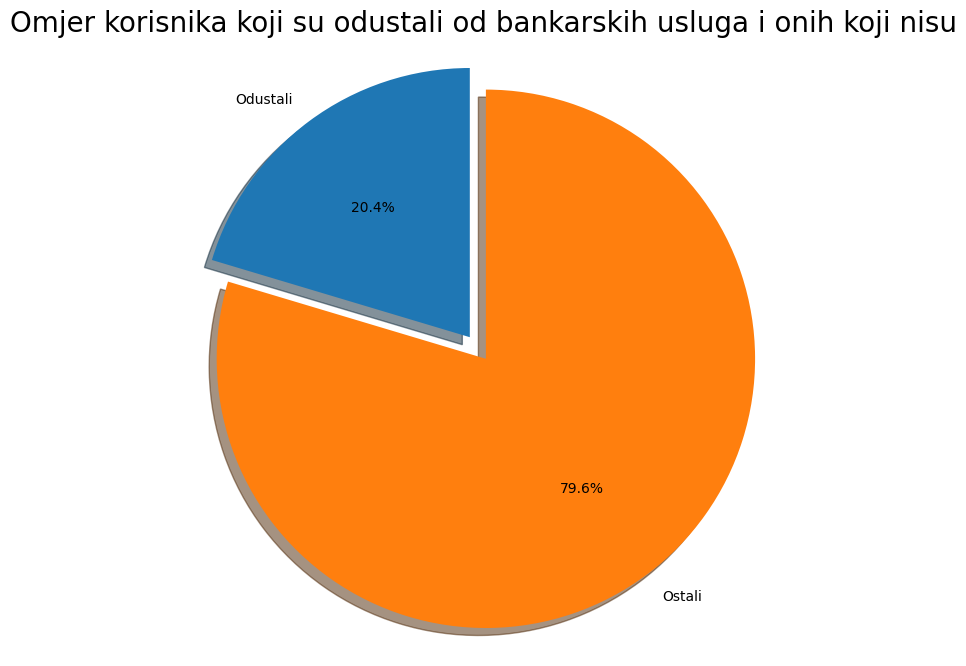

In [7]:
labels = 'Odustali', 'Ostali'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Omjer korisnika koji su odustali od bankarskih usluga i onih koji nisu", size = 20)
plt.show()

Iz grafa možemo vidjeti da otprilike jedna petina korisnika bankarskih usluga i odustane od njih. S ovakvim skupom podataka, za očekivati je da će predikcija korisnika koji nastavljaju koristiti bankarske usluge biti puno bolja od predikcije korisnika koji od istih odustaju. Taj problem može se riješiti na jedan od sljedećih načina:
1) **Tehnike uzorkovanja** <br>
Slučajnim odabirom uklanjamo primjere iz prezastupljene klase (u ovom slučaju korisnici koji nastavljaju s korištenjem bankarskih usluga) ili generiramo nove umjetne primjere podzastupljene klase (u ovom slučaju korisnici koji odustaju od bankarskih usluga) dupliciranjem ili nekom vrstom uzorkovanja iz postojećih primjera. <br>
2) **Težinska korekcija** <br>
Primjerima koji pripadaju podzastupljenoj klasi dajemo veće težine tijekom treniranja modela.

U kodu u nastavku, korigirati ćemo skup podataka generiranjem novih sintetičkih primjera za podzastupljenu klasu koristeći MIT-evu python biblioteku "imbalanced-learn", odnosno njenu SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous features) metodu.



In [9]:
from imblearn.over_sampling import SMOTENC

# Separate features and target variable
X = df.drop(columns=['Exited'])  # Assuming 'Exited' is the target column
y = df['Exited']

# Identify categorical columns
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']  

# Find indices of categorical columns
categorical_indices = [X.columns.get_loc(col) for col in categorical_columns]

# Apply SMOTE considering categorical and numerical features
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_balanced, y_balanced = smote_nc.fit_resample(X, y)

# Create a new DataFrame with balanced data
balanced_data = pd.DataFrame(X_balanced, columns=X.columns)
balanced_data['Exited'] = y_balanced
df = balanced_data

Prikažimo naš novi balansirani skup podataka.

In [10]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


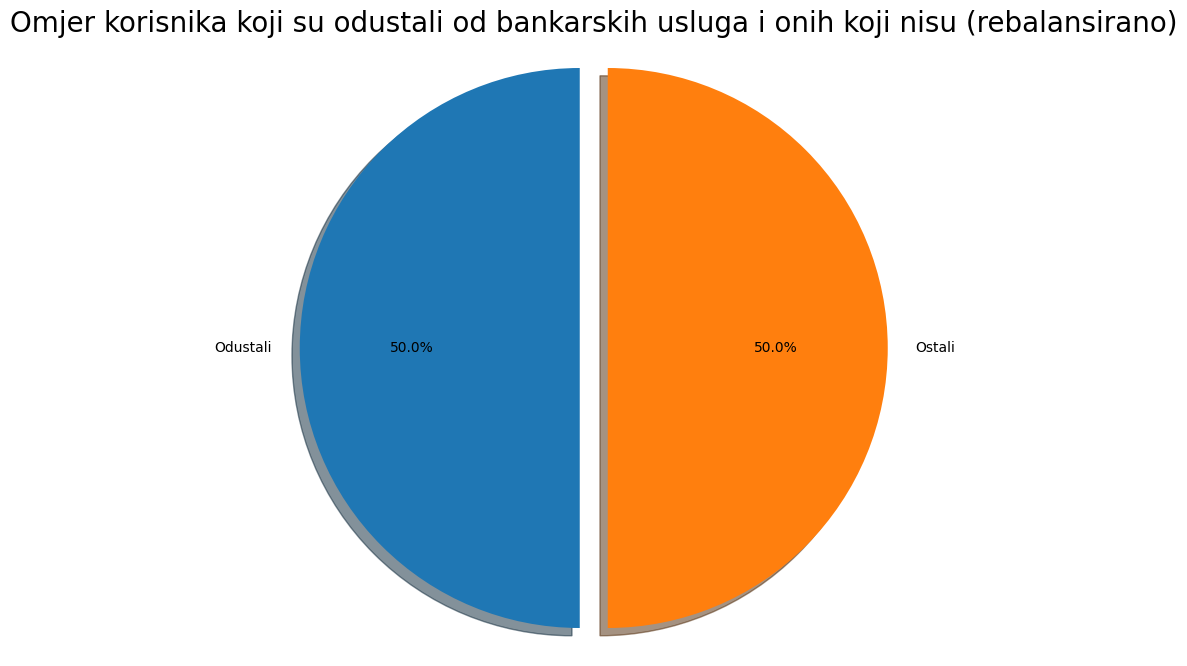

In [11]:
labels = 'Odustali', 'Ostali'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Omjer korisnika koji su odustali od bankarskih usluga i onih koji nisu (rebalansirano)", size = 20)
plt.show()

Kao što je vidljivo iz grafa, SMOTENC uistinu radi. SMOTENC generira sintetičke podatke pomoću sljedećih koraka:
1) **Identifikacija kategoričkih podataka** <br>
Korisnik SMOTENC metode prvo mora definirati koji od stupaca skupa podataka su kategorički. Iako SMOTENC koristi i numeričke i kategoričke podatke, potrebno je definirati numeričke jer se oni obrađuju na nešto drugačiji način. <br>
2) **Uzorkovanje** <br>
SMOTENC pronalazi primjere koji pripadaju podzastupljenoj klasi, a koji su si međusobno bliski u prostoru primjera. <br>
3) **Generiranje sintetičkih primjera** <br>
SMOTENC generira nove primjere slučajnim rekombiniranjem primjera uzorkovanih u prethodnom koraku. <br>
4) **Balansiranje klasa** <br>
Novi primjeri podzaastupljene klase generiraju se sve dok klase ne budu savršeno balansirane.<br>

Nakon što smo riješili ovaj problem, valjalo bi se pozabaviti idućim korakom analize podataka - korelacijskom matricom. S obzirom na to da su korelacijske matrice inače dizajnirane za numeričke podatke, da bismo se uopće mogli baviti korelacijom koja uključuje kategoričke podatke, morati ćemo konvertirati najproblematičniji stupac istih - stupac "Geography" - u neki oblik numeričkog podatka. Da bismo to postigli, poslužiti ćemo se kodiranjem oznaka, odnosno svakoj od oznaka u tom stupcu pridružiti ćemo neku brojčanu vrijednost (npr. Spain = 0 ). U kodu u nastavku, generirati ćemo korelacijsku matricu stupaca našeg skupa podataka.

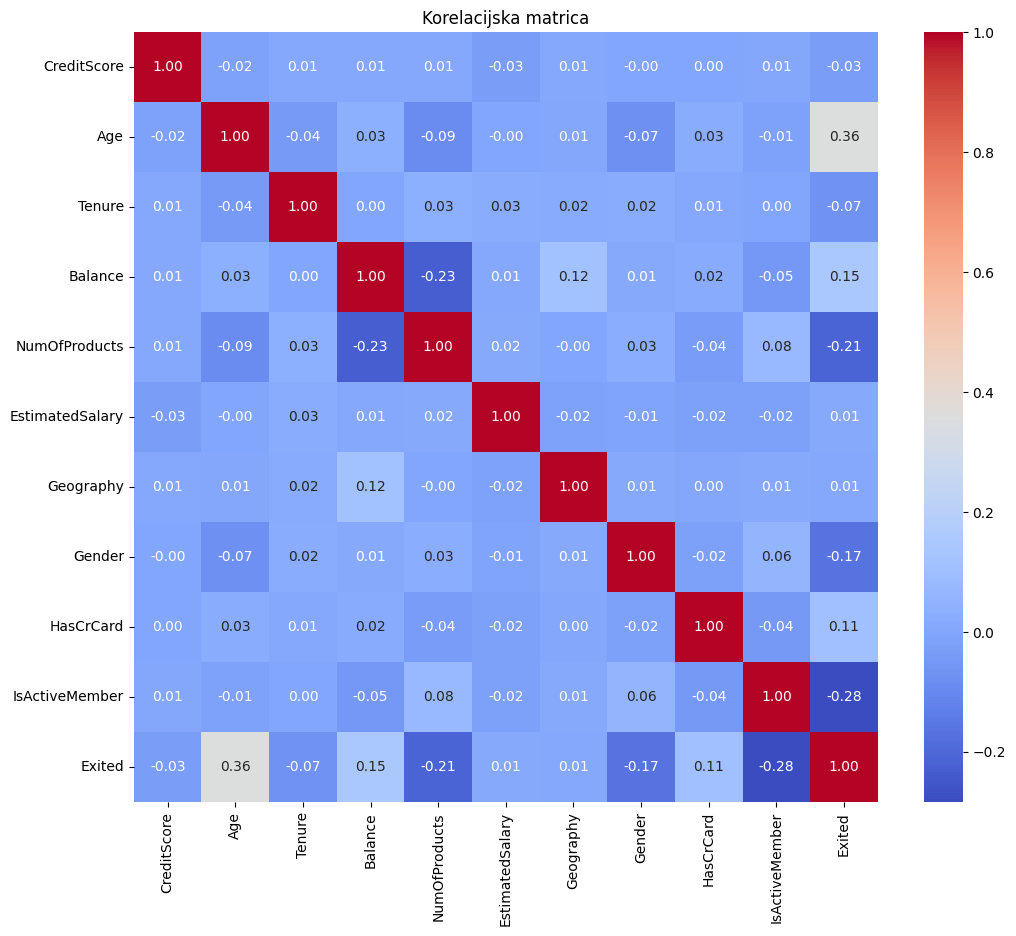

In [12]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Create lists of numerical and categorical columns
all_columns = numerical_columns + categorical_columns

# Select columns from the DataFrame
df_selected = df[all_columns]
all_corr = df_selected.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(all_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelacijska matrica')
plt.show()

Iz matrice iznad vidimo da bi najveći utjecaj na odustajanje od bankarskih usluga trebala imati dob korisnika. Nakon toga, najveći utjecaj bi trebalo imati stanje na računu korisnika bankarskih usluga.

# Priprema podataka za treniranje
Prvo što ćemo napraviti je podijeliti skup podataka na skup za treniranje i skup za testiranje. Podjelu ćemo obaviti u često korištenom omjeru 70:30.

In [13]:
from sklearn.model_selection import train_test_split

# Define features (independent variables) and target variable
features = df.drop('Exited', axis=1)  # Adjust 'target_column_name' to your target column
target = df['Exited']  # Adjust 'target_column_name' to your target column

# Split the data into train and test sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# 'X_train' and 'X_test' contain the feature variables, while 'y_train' and 'y_test' contain the target variable

U binarnim kategoričkim varijablama mijenjamo sve 0 u -1. Zatim skaliramo kontinuirane numeričke značajke MinMax scalerom.

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Separating columns by data type
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Creating DataFrames for continuous and categorical variables
train_numeric = X_train[numeric_columns]

scaler = MinMaxScaler()

# Fit and transform the scaler on your training numeric data
X_train[numeric_columns] = scaler.fit_transform(train_numeric)

columns_to_replace = ['HasCrCard', 'IsActiveMember', 'Gender']  

# Replace 0 with -1 in the specified columns
X_train[columns_to_replace] = X_train[columns_to_replace].replace(0, -1)

# Display the updated X_train DataFrame
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6428,0.554,0.5,-1.0,0.283784,0.5,0.496564,0.000000,1.0,-1.0,0.465650
9992,0.752,1.0,1.0,0.243243,0.2,0.000000,0.000000,1.0,-1.0,0.975997
12320,0.762,0.0,-1.0,0.378378,0.7,0.000000,0.000000,1.0,-1.0,0.166720
5896,0.788,1.0,1.0,0.162162,0.1,0.510427,0.000000,1.0,-1.0,0.607628
11840,0.560,0.5,1.0,0.283784,0.2,0.441896,0.333333,1.0,-1.0,0.081755


In [15]:
###Isto za test data za svaki slučaj, da ne bi bilo problema kasnije

from sklearn.preprocessing import MinMaxScaler

# Creating DataFrames for continuous and categorical variables
test_numeric = X_test[numeric_columns]

scaler = MinMaxScaler()

# Fit and transform the scaler on your training numeric data
X_test[numeric_columns] = scaler.fit_transform(test_numeric)

columns_to_replace = ['HasCrCard', 'IsActiveMember', 'Gender']  

# Replace 0 with -1 in the specified columns
X_test[columns_to_replace] = X_test[columns_to_replace].replace(0, -1)
X_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6126,0.370,0.0,-1.0,0.148649,0.5,0.000000,0.333333,-1.0,1.0,0.263528
7093,0.512,0.5,-1.0,0.310811,0.4,0.588148,0.000000,1.0,-1.0,0.782540
1659,0.660,1.0,-1.0,0.175676,0.9,0.531205,0.333333,1.0,1.0,0.505760
15727,0.698,0.0,-1.0,0.391892,0.6,0.285073,0.000000,1.0,-1.0,0.072168
9682,0.672,0.5,-1.0,0.283784,0.4,0.699248,0.333333,1.0,-1.0,0.814273


# Jednostavne metode strojnog učenja

In [16]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Logistička regresija

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      5537
           1       0.73      0.74      0.73      5611

    accuracy                           0.73     11148
   macro avg       0.73      0.73      0.73     11148
weighted avg       0.73      0.73      0.73     11148



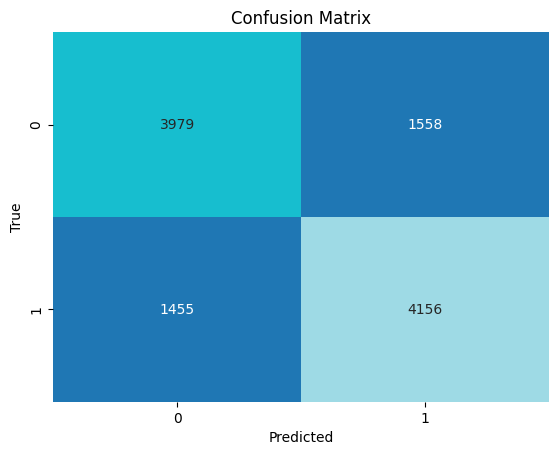

In [17]:
log_primal = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=250,n_jobs=None, 
                                penalty='l2', random_state=None, solver='lbfgs',tol=1e-05, verbose=0, warm_start=False)
log_primal.fit(X_train,y_train)

print(classification_report(y_train, log_primal.predict(X_train)))

y_train_pred = log_primal.predict(X_train)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="tab20", cbar=False,
            xticklabels=log_primal.classes_, yticklabels=log_primal.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Stroj potpornih vektora (SVM)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      5537
           1       0.82      0.82      0.82      5611

    accuracy                           0.82     11148
   macro avg       0.82      0.82      0.82     11148
weighted avg       0.82      0.82      0.82     11148



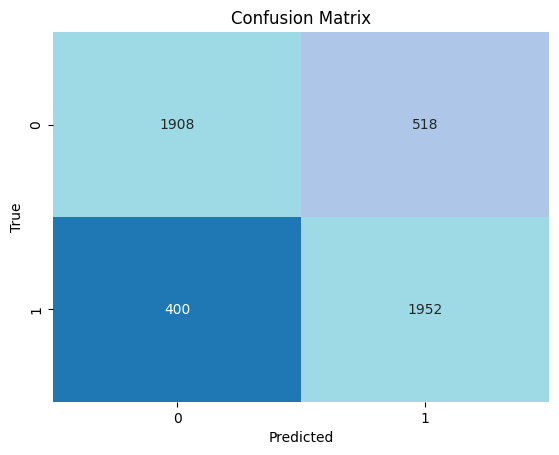

In [18]:
#Fit SVM with RBF kernel

from sklearn.svm import SVC

# Initialize and fit the SVM model
SVM_RBF = SVC(C=100, gamma=0.1, kernel='rbf', probability=True)
SVM_RBF.fit(X_train, y_train)

# Predict and print classification report
y_pred_train = SVM_RBF.predict(X_train)
print(classification_report(y_train, y_pred_train))

conf_matrix = confusion_matrix(y_test, SVM_RBF.predict(X_test))

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="tab20", cbar=False,
            xticklabels=SVM_RBF.classes_, yticklabels=SVM_RBF.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      5537
           1       0.82      0.81      0.81      5611

    accuracy                           0.81     11148
   macro avg       0.81      0.81      0.81     11148
weighted avg       0.81      0.81      0.81     11148



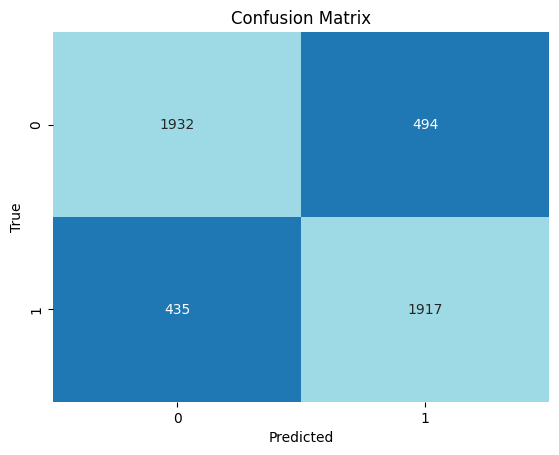

In [19]:
# Fit SVM with Pol Kernel
SVM_POL = SVC(C=100, gamma=0.1, kernel='poly', probability=True)
SVM_POL.fit(X_train,y_train)

y_pred_train = SVM_POL.predict(X_train)
print(classification_report(y_train, y_pred_train))

conf_matrix = confusion_matrix(y_test, SVM_RBF.predict(X_test))

conf_matrix = confusion_matrix(y_test, SVM_POL.predict(X_test))

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="tab20", cbar=False,
            xticklabels=SVM_POL.classes_, yticklabels=SVM_POL.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Kompozitne metode strojnog učenja

XGBoost

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:08:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.85      0.84      0.85      5537
           1       0.85      0.85      0.85      5611

    accuracy                           0.85     11148
   macro avg       0.85      0.85      0.85     11148
weighted avg       0.85      0.85      0.85     11148



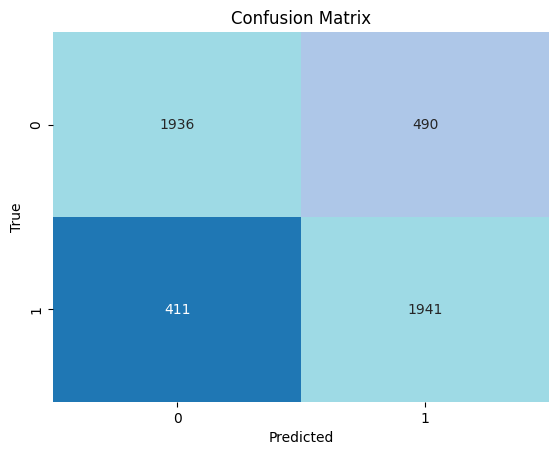

In [20]:
from xgboost import XGBClassifier

# Fit the XGBClassifier

XGB = XGBClassifier(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=1, 
    colsample_bytree=1, 
    gamma=0.01, 
    learning_rate=0.1, 
    max_delta_step=0, 
    max_depth=7,
    min_child_weight=5, 
    #missing=np.nan, 
    n_estimators=20, 
    n_jobs=1, 
    nthread=None, 
    objective='binary:logistic', 
    random_state=0, 
    reg_alpha=0, 
    reg_lambda=1, 
    scale_pos_weight=1, 
    seed=None, 
    silent=True, 
    subsample=1
)
XGB.fit(X_train, y_train)

y_pred_train = XGB.predict(X_train)
print(classification_report(y_train, y_pred_train))

conf_matrix = confusion_matrix(y_test, XGB.predict(X_test))

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="tab20", cbar=False,
            xticklabels=XGB.classes_, yticklabels=XGB.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Bagging algoritam

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.80      0.81      2426
           1       0.80      0.81      0.80      2352

    accuracy                           0.81      4778
   macro avg       0.81      0.81      0.81      4778
weighted avg       0.81      0.81      0.81      4778



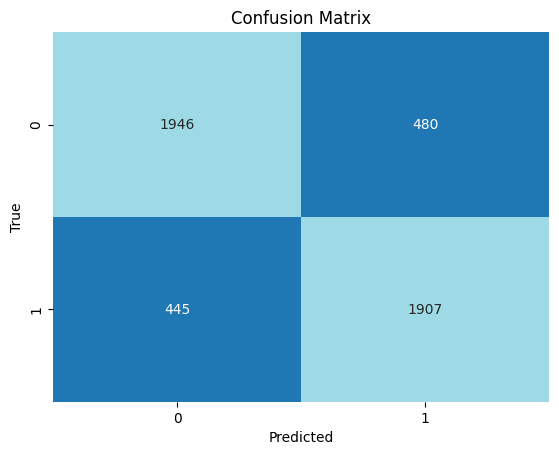

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#Fit the bagging classifier

base_estimator = DecisionTreeClassifier(max_depth=8)

bagging_classifier = BaggingClassifier(base_estimator=base_estimator, n_estimators=27, random_state=42)
bagging_classifier.fit(X_train, y_train)


y_pred = bagging_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, bagging_classifier.predict(X_test))

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="tab20", cbar=False,
            xticklabels=bagging_classifier.classes_, yticklabels=bagging_classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Od RandomForest metode sam odustala jer se nakon 2 sata još uvijek nije "izvrtila", iako se sve ostale metode "izvrte" u maksimalno 10-ak minuta. Metoda je odbačena iz daljnjih razmatranja po kriteriju vremenske neisplativosti.

# Promatranje rezultata

In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

y = y_train
X = X_train

auc_log_primal, fpr_log_primal, tpr_log_primal = get_auc_scores(y, log_primal.predict(X),log_primal.predict_proba(X)[:,1])
auc_SVM_RBF, fpr_SVM_RBF, tpr_SVM_RBF = get_auc_scores(y, SVM_RBF.predict(X),SVM_RBF.predict_proba(X)[:,1])
auc_SVM_POL, fpr_SVM_POL, tpr_SVM_POL = get_auc_scores(y, SVM_POL.predict(X),SVM_POL.predict_proba(X)[:,1])
auc_bag, fpr_bag, tpr_bag = get_auc_scores(y, bagging_classifier.predict(X),bagging_classifier.predict_proba(X)[:,1])
auc_XGB, fpr_XGB, tpr_XGB = get_auc_scores(y, XGB.predict(X),XGB.predict_proba(X)[:,1])

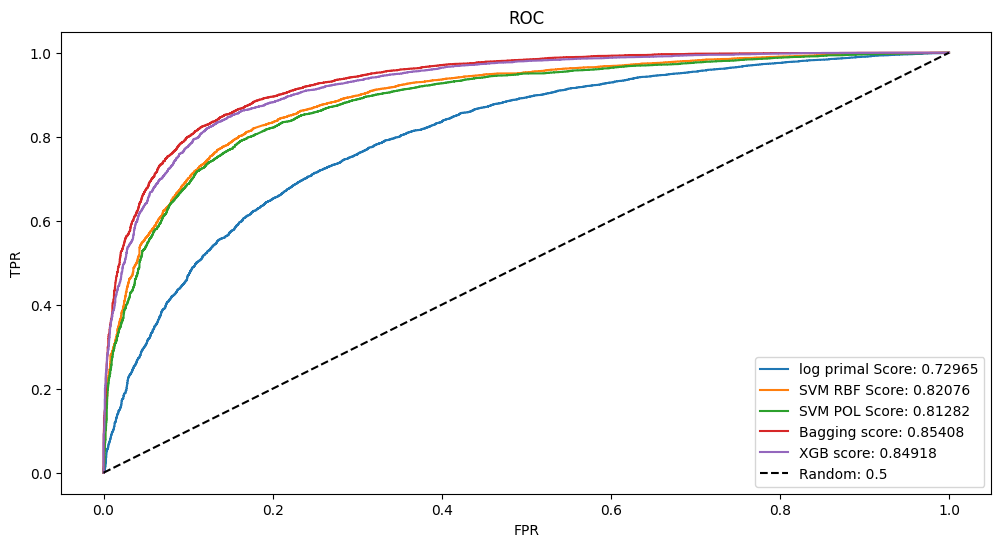

In [24]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_log_primal, tpr_log_primal, label = 'log primal Score: ' + str(round(auc_log_primal, 5)))
plt.plot(fpr_SVM_RBF, tpr_SVM_RBF, label = 'SVM RBF Score: ' + str(round(auc_SVM_RBF, 5)))
plt.plot(fpr_SVM_POL, tpr_SVM_POL, label = 'SVM POL Score: ' + str(round(auc_SVM_POL, 5)))
plt.plot(fpr_bag, tpr_bag, label = 'Bagging score: ' + str(round(auc_bag, 5)))
plt.plot(fpr_XGB, tpr_XGB, label = 'XGB score: ' + str(round(auc_XGB, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

Bagging je najbolji.